In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
mpl.use('Agg')
mpl.rcParams['agg.path.chunksize'] = 10000
from matplotlib import pyplot as plt
# from PIL import Image
%matplotlib inline

In [2]:
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# set_session(tf.Session(config=config))

#  Data Set

In [3]:
def eachFile(filepath):
    pathDir = os.listdir(filepath)
    for filename in pathDir:
        if os.path.splitext(filename)[1] != ".csv":
            pathDir.remove(filename)
    pathDir.sort(key = lambda x: int(x[:-4]))
    path = []
    for allDir in pathDir:
        child = os.path.join('%s%s'%(filepath,allDir))
        path.append(child)
    return path

In [4]:
## train: 'first data':'../01-TrainingData-qLua/',three current one vibration
## test: 'first data':'../02-TestingData-poL3/',three current one vibration
path = {'train':'../01-TrainingData-additional/','test':'../02-TestingData-keD1/','final':'../final/03-FinalData-r1el/'}
floder = {'train':["01/","02/","03/"],'test':["01/","02/","03/","04/","05/"],'final':["01/","02/","03/","04/"]}
## Data sample from PLC or Sensor
source = 'Sensor1/'
start_time = {'test':[40,70,50,70,120],'final':[60,30,83,63]}
test_entire = [194,172,290,186,210]
sample_rate = 25600

## Frequent domain

In [5]:
# from python_speech_features import logfbank,delta
from scipy import signal

In [6]:
def load_label(path,keys,floder,source,start_time,test_entire,file_leng):
    label = []
    use_time = []
    k = 0
    for key in keys:
        if key == 'test':
            k = 3
        for i in range(len(floder[key])):
            print(floder[key][i])
            file_set = eachFile(path[key]+floder[key][i]+source)
            entire_life = len(file_set)*5
            for j in range(len(file_set)):
                file_name = int(file_set[j].split('/')[-1].split('.')[0])
                if key=='train':
                    use = file_name*5
                    residual_life = entire_life - use
                else:
                    use = file_name*5+start_time[key][i]
                    residual_life = test_entire[i] - use

                label.extend([residual_life]*file_leng[i+k][j])
                use_time.extend([use]*file_leng[i+k][j])
    label = np.reshape(np.array(label),(-1,1))
    use_time = np.array(use_time)
    print(label.shape,use_time.shape) 

    return label,use_time

In [20]:
def load_frequent_feature(path,keys,floder,source,sample_rate):
    data = []
    file_leng = []
    for key in keys:
        for i in range(len(floder[key])):
            print(floder[key][i])
            file_set = eachFile(path[key]+floder[key][i]+source)
            each_leng = []
            for file in file_set:
                each_data = pd.read_csv(file)
                each_data = each_data[:len(each_data)//sample_rate*sample_rate]
                each_data = np.reshape(np.array(each_data),(-1,sample_rate,4))
                for each_sample in each_data:
                    each_feature = signal.spectrogram(each_sample,sample_rate,window='hamming',nfft=256,nperseg=256,
                                                      scaling='spectrum',axis=0)
                    ## each_feature:(129, 4, 114)
                    #each_feature = logfbank(each_sample,sample_rate,winlen=0.04,winstep=0.02,nfft=1024,nfilt=40)
                    data.append(np.log(each_feature[2]))
                each_leng.append(len(each_data))
            file_leng.append(each_leng)
    data = np.array(data)
    print(data.shape,len(file_leng)) 

    return data,file_leng

In [41]:
data,leng = load_frequent_feature(path,['train','test'],floder,source,sample_rate)

01/
02/
03/
01/
02/
03/
04/
05/
(10667, 129, 114) 8


In [15]:
leng = np.array(leng)

In [42]:
label,use_time = load_label(path,['train','test'],floder,source,start_time,test_entire,leng)

01/
02/
03/
01/
02/
03/
04/
05/
(10667, 1) (10667,)


In [21]:
final_data,final_leng = load_frequent_feature(path,['final'],floder,source,sample_rate)

01/
02/
03/
04/
(2400, 129, 4, 114) 4


In [22]:
label_final,use_time_final = load_label(path,['final'],floder,source,start_time,test_entire,final_leng)

01/
02/
03/
04/
(2400, 1) (2400,)


In [40]:
permutation = np.random.permutation(label_train.shape[0])
data_from_train = data_from_train[permutation]
label_train = label_train[permutation]
use_time_train = use_time_train[permutation]

In [123]:
permutation = np.random.permutation(label_test.shape[0])
data_from_test = data_from_test[permutation]
label_test = label_test[permutation]
use_time_test = use_time_test[permutation]

In [10]:
import sys

In [11]:
sys.getsizeof(data)

1254951344

In [43]:
permutation = np.random.permutation(label.shape[0])
data = data[permutation]
label = label[permutation]
use_time = use_time[permutation]

In [143]:
import gc
del train_data,train_label,train_use_time
del valid_data,valid_label,valid_use_time
gc.collect()

44070

In [14]:
len(data)*0.2

2133.4

# Model 

In [11]:
from keras import models as M
from keras import layers as L
from keras import optimizers
from keras import metrics
from keras import losses
import functools
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.


In [13]:
def evaluation_metric(y_true, y_pred):
    y_true, y_pred = tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1])
    er = y_true - y_pred
    mask_n, mask_p = (er<=0), (er>0)
    er_n, er_p = tf.boolean_mask(er, mask_n), tf.boolean_mask(er, mask_p)
    score_n = tf.exp(-tf.log(0.5)*er_n/5)
    score_p = tf.exp(tf.log(0.5)*er_p/20)
    score = tf.concat([score_n, score_p], 0)
    score = tf.reduce_mean(score)*100
    return score

### Training

In [72]:
graph = None
model = None

In [13]:
def model_CNN(input_shape):
    x_input = L.Input(shape=input_shape)
    use_input = L.Input(shape=(1,))
    filter_size = (3,3)
    print(x_input.shape)
    print(use_input)
#     x = L.BatchNormalization(axis=3)(x_input)
    x = L.Conv2D(32,filter_size,activation='relu',padding='same')(x_input)
    x = L.Conv2D(32,filter_size,activation='relu',padding='same')(x)
    x = L.MaxPool2D((3,3),strides=(2,2))(x)
    x = L.Conv2D(64,filter_size,activation='relu',padding='same')(x)
    x = L.Conv2D(64,filter_size,activation='relu',padding='same')(x)
    x = L.MaxPool2D((3,3),strides=(2,2))(x)
    x = L.Conv2D(128,filter_size,activation='relu',padding='same')(x)
    x = L.Conv2D(128,filter_size,activation='relu',padding='same')(x)
    x = L.MaxPool2D((3,3),strides=(2,2))(x)
    x = L.Conv2D(256,filter_size,activation='relu',padding='same')(x)
    x = L.Conv2D(256,filter_size,activation='relu',padding='same')(x)
    x = L.MaxPool2D((3,3),strides=(2,2))(x)
#     x = L.Conv2D(512,filter_size,activation='relu')(x)
#     x = L.Conv2D(512,filter_size,activation='relu')(x)
#     x = L.MaxPool2D((3,3),strides=(2,2))(x)
#     x = L.Conv2D(256,(1,1),activation='relu')(x)
    x = L.Conv2D(128,(1,1),activation='relu')(x)
    x = L.Conv2D(64,(1,1),activation='relu')(x)
    
    x = L.Flatten()(x)
    x = L.Dense(1024,activation="relu")(x)
#     x = L.Dropout(0.5)(x)
    x = L.Dense(1024,activation="relu")(x)
#     x = L.Dropout(0.5)(x)
#     print(x)
#     print(type(x))
    x = L.concatenate([x,use_input])

    y = L.Dense(1)(x)
    
    model = M.Model(inputs=[x_input,use_input], outputs=y, name="VGG_CNN")
    return model

In [14]:
graph = tf.get_default_graph()
model = model_CNN((129,114,1))

(?, 129, 114, 1)
Tensor("input_2:0", shape=(?, 1), dtype=float32)


In [15]:
Adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=Adam, loss=losses.mse, metrics=[evaluation_metric])

In [35]:
data_from_train.shape

(7667, 129, 4, 114)

In [36]:
data_from_test.shape

(3000, 129, 4, 114)

In [44]:
data = data.reshape((-1,129,114,1))

In [45]:
index = int(len(data)*0.2)

In [46]:
model = load_model('v3_spec.h5',{"evaluation_metric":evaluation_metric})

In [47]:
checkpoint = ModelCheckpoint(filepath="./v3_spec2.h5",monitor='val_evaluation_metric',verbose=1,save_best_only='True',
                             mode='max',period=1)
# tensorboard = TensorBoard(log_dir='log(./)')
callback_lists = [checkpoint]  #因为callback是list型,必须转化为list

In [48]:
history = model.fit([data[index:],use_time[index:]], label[index:], batch_size=32, epochs=50,verbose=1,
                    validation_data=([data[:index],use_time[:index]],label[:index]),callbacks=callback_lists)

Train on 8534 samples, validate on 2133 samples
Epoch 1/50
8534/8534 [==============================] - 10s 1ms/step - loss: 974.0720 - evaluation_metric: 30.9847 - val_loss: 1014.4223 - val_evaluation_metric: 36.9912

Epoch 00001: val_evaluation_metric improved from -inf to 36.99122, saving model to ./v3_spec2.h5
Epoch 2/50
8534/8534 [==============================] - 9s 1ms/step - loss: 966.6010 - evaluation_metric: 30.9575 - val_loss: 953.2700 - val_evaluation_metric: 28.9346

Epoch 00002: val_evaluation_metric did not improve from 36.99122
Epoch 3/50
8534/8534 [==============================] - 9s 1ms/step - loss: 967.1228 - evaluation_metric: 30.8437 - val_loss: 953.6947 - val_evaluation_metric: 29.8040

Epoch 00003: val_evaluation_metric did not improve from 36.99122
Epoch 4/50
8534/8534 [==============================] - 9s 998us/step - loss: 978.6997 - evaluation_metric: 31.2178 - val_loss: 956.9422 - val_evaluation_metric: 30.9232

Epoch 00004: val_evaluation_metric did not im

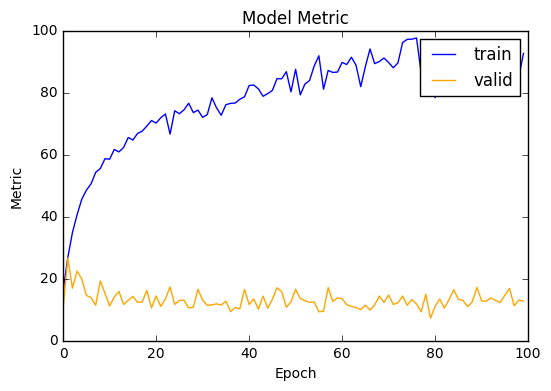

In [41]:
plt.plot(history.history['evaluation_metric'],'b',label='train')
plt.plot(history.history['val_evaluation_metric'],'orange',label='valid')
plt.legend()
plt.title('Model Metric')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

In [10]:
from keras.models import load_model

Using TensorFlow backend.


### Predicting

In [11]:

from scipy.stats import mode

In [14]:
model = load_model('c_spec.h5',{"evaluation_metric":evaluation_metric})

In [62]:
def compute_ai(y_true, y_pred):
    er = y_true - y_pred
    score = np.where(np.greater(er,0),np.exp(np.log(0.5)*er/20),np.exp(-np.log(0.5)*er/5))
    score = score*100
    return score

### Testing Data

In [53]:
data_from_test.shape

(3000, 129, 4, 114)

In [115]:
test_data = data_from_test[:,:,3,:].reshape((-1,129,114,1))

In [54]:
test_data.shape

(3000, 129, 114, 1)

In [55]:
use_time_test.shape

(3000,)

In [116]:
test_pred = model.predict([test_data,use_time_test])

137.43 [ 147.] 93.7983


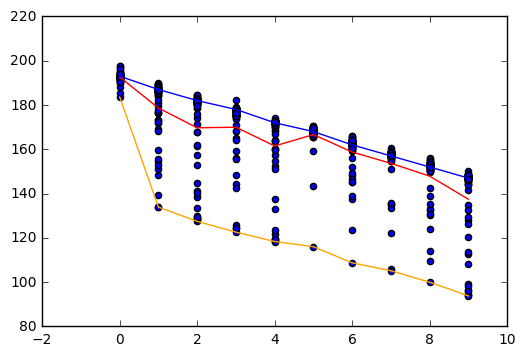

114.617 [ 118.] 66.9769


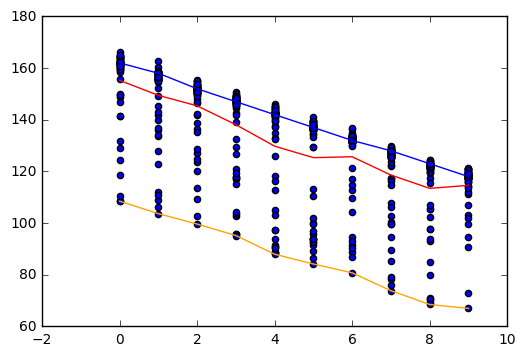

125.897 [ 138.] 83.9644


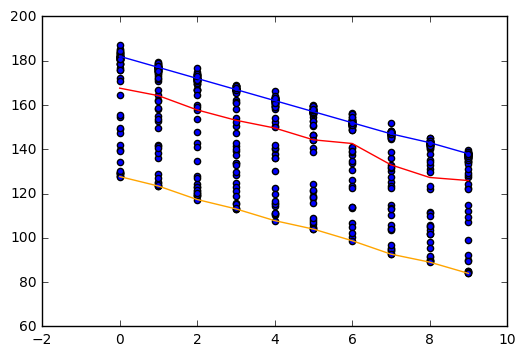

114.466 [ 118.] 68.4784


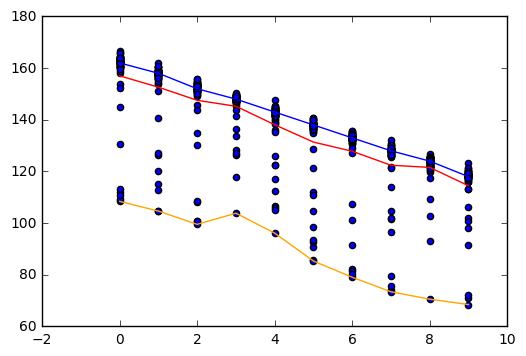

61.7654 [ 68.] 15.2778


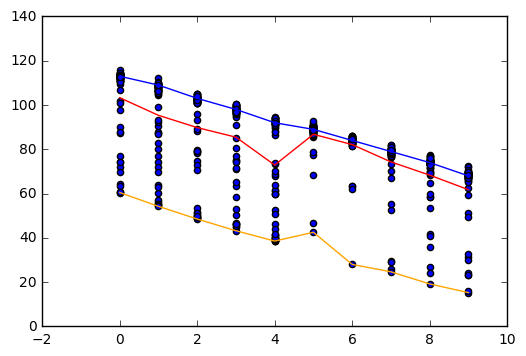

In [117]:
x = list()
for i in range(10):
    x += [i]*60
preds = test_pred.reshape(5, -1)
pred_mode = []
pred_mean = []
pred_min = []
for pred in preds:
    plt.scatter(x, pred)
    each_file_pred = pred.reshape(-1, 60)
    mean_val = each_file_pred.mean(axis=-1)
    min_val = np.min(each_file_pred,axis=-1)
    mode_val = mode(np.round(each_file_pred), axis=-1)[0]
    pred_mode.append(mode_val[-1])
    pred_mean.append(mean_val[-1])
    pred_min.append(min_val[-1])
    print(mean_val[-1], mode_val[-1],min_val[-1])
    plt.plot(mean_val,'r')
    plt.plot(mode_val,'b')
    plt.plot(min_val,'orange')
    plt.show()

In [118]:
pred_mode = np.reshape(np.array(pred_mode),(-1,))
true = np.array([104,52,190,66,40])
print(pred_mean)
print(pred_mode)
print(pred_min)

[137.42967, 114.61658, 125.89671, 114.4664, 61.765438]
[ 147.  118.  138.  118.   68.]
[93.798264, 66.976936, 83.964424, 68.478371, 15.277786]


In [120]:
mean_ai = np.round(compute_ai(true,pred_mean),2)
mode_ai = np.round(compute_ai(true,pred_mode),1)
min_ai = np.round(compute_ai(true,pred_min),2)
print(mean_ai)
print(mode_ai)
print(min_ai)

[  0.97   0.02  10.84   0.12   4.89]
[  0.3   0.   16.5   0.1   2.1]
[ 70.22  12.54   2.54  70.92  42.45]


In [93]:
np.mean(compute_ai(true,pred_mode))

27.984524898590813

In [95]:
np.mean(compute_ai(true,pred_min))

24.900795756437706

### Final Data

In [42]:
model = load_model('v1_spec.h5',{"evaluation_metric":evaluation_metric})

In [43]:
test_data = final_data[:,:,0,:].reshape((-1,129,114,1))

In [22]:
use_time_final.shape

(2400,)

In [44]:
final_pred = model.predict([test_data,use_time_final])

In [24]:
final_pred.shape

(2400, 1)

In [47]:
df = pd.DataFrame(columns=['true','pred'])
df.true = test_label ##(-1,)
df.pred = test_pred  ##(-1,)
mean_pre = df.groupby(['true']).mean()
mode_pre = df.groupby(['true']).agg(lambda x: mode(x)[0][0])

129.359 [ 130.] 97.1865


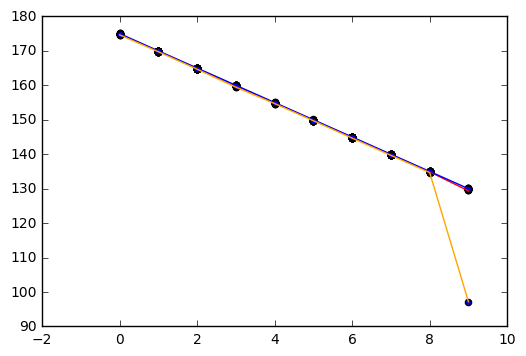

159.887 [ 160.] 159.38


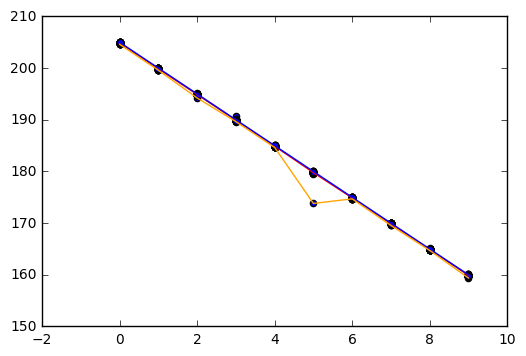

106.897 [ 107.] 106.722


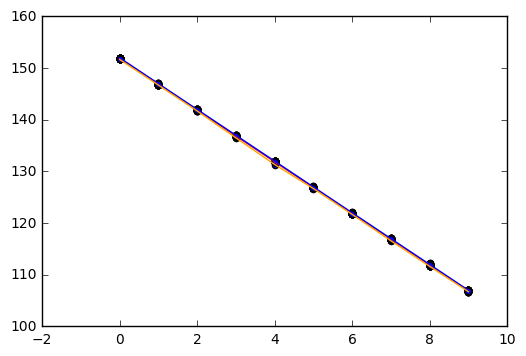

126.485 [ 127.] 117.285


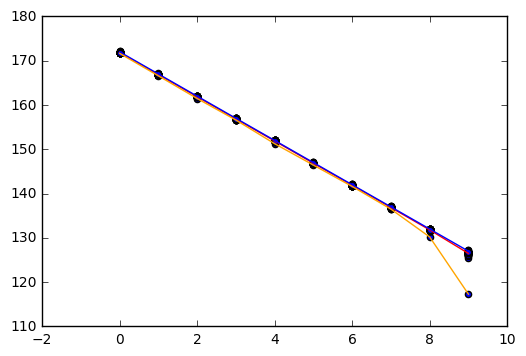

In [45]:
x = list()
for i in range(10):
    x += [i]*60
preds = final_pred.reshape(4, -1)
pred_mode = []
pred_mean = []
pred_min = []
for pred in preds:
    plt.scatter(x, pred)
    each_file_pred = pred.reshape(-1, 60)
    mean_val = each_file_pred.mean(axis=-1)
    min_val = np.min(each_file_pred,axis=-1)
    mode_val = mode(np.round(each_file_pred), axis=-1)[0]
    pred_mode.append(mode_val[-1])
    pred_mean.append(mean_val[-1])
    pred_min.append(min_val[-1])
    print(mean_val[-1], mode_val[-1],min_val[-1])
    plt.plot(mean_val,'r')
    plt.plot(mode_val,'b')
    plt.plot(min_val,'orange')
    plt.show()

In [46]:
pred_mode = np.reshape(np.array(pred_mode),(-1,))
true = np.array([104,52,190,66,40])
print(pred_mean)
print(pred_mode)
print(pred_min)

[129.35933, 159.88745, 106.8971, 126.48547]
[ 130.  160.  107.  127.]
[97.186501, 159.37958, 106.72223, 117.28506]


In [83]:
np.mean(compute_ai(true,pred_mean))

6.4435355207460159

In [84]:
np.mean(compute_ai(true,pred_mode))

6.6006516493900778

## Final

In [ ]:
residual_data = pd.DataFrame(columns=["filename","answer"])
residual_data["filename"] = ["TestingData01","TestingData02","TestingData03","TestingData04","TestingData05"]
residual_data["answer"] = residual_life
residual_data.to_csv("result.csv",index=False)

In [31]:
normalize = []
for i in range(10):
    each = [(9-i)*5]*60
    normalize.append(each)
normalize = np.reshape(np.array(normalize),(1,10,60))
residual_life = np.reshape(np.array(residual_life),(-1,10,60))
result = residual_life-normalize
result = np.reshape(result,(4,-1))
mean_pred = np.mean(result,axis=-1)
print(mean_pred)
mode_pred = mode(np.round(result),axis=-1)[0]
print(mode_pred)

[ 126.84507642  159.26176208  103.46774733  123.4937512 ]
[[ 130.]
 [ 161.]
 [ 107.]
 [ 127.]]
